# Notebook 2 — Analyse Multivariée, ACP & Clustering
## P11 — Étude de marché : Disponibilité alimentaire mondiale (2017)
---
**Enchaînement :**
1. Chargement des données nettoyées (sortie du Notebook 1)
2. Matrice de corrélations
3. ACP — centrage, ébouli, cercle des corrélations, projection des individus
4. Clustering — CAH (Ward) puis KMeans, comparaison, nombre optimal
5. Interprétation des clusters & recommandations

---
## 1. Imports et chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook', font_scale=1.05)

# --- Chargement (même pipeline que Notebook 1 pour garantir la reproductibilité) ---
df_alim = pd.read_excel('DisponibiliteAlimentaire_2017.xlsx')
df_pop  = pd.read_csv('Population_2000_2018.csv')

# Population 2017
pop_2017 = (df_pop[df_pop['Année'] == 2017][['Zone','Valeur']]
            .rename(columns={'Valeur':'Population_1000'})
            .reset_index(drop=True))

# Agrégation
vars_somme   = ['Production','Importations - Quantité','Exportations - Quantité',
                'Pertes','Nourriture','Disponibilité intérieure',
                'Variation de stock','Aliments pour animaux']
vars_moyenne = ['Disponibilité alimentaire (Kcal/personne/jour)',
                'Disponibilité alimentaire en quantité (kg/personne/an)',
                'Disponibilité de matière grasse en quantité (g/personne/jour)',
                'Disponibilité de protéines en quantité (g/personne/jour)']

dfs = []
for var in vars_somme:
    dfs.append(df_alim[df_alim['Élément']==var].groupby('Zone')['Valeur']
               .sum().reset_index().rename(columns={'Valeur':var}))
for var in vars_moyenne:
    dfs.append(df_alim[df_alim['Élément']==var].groupby('Zone')['Valeur']
               .mean().reset_index().rename(columns={'Valeur':var}))

df_pays = dfs[0]
for d in dfs[1:]:
    df_pays = df_pays.merge(d, on='Zone', how='outer')

df = df_pays.merge(pop_2017, on='Zone', how='inner').dropna().reset_index(drop=True)

# Feature engineering
eps = 0.001
df['Taux_dependance_alimentaire'] = df['Importations - Quantité'] / (df['Disponibilité intérieure'] + eps)
df['Ratio_pertes']                = df['Pertes'] / (df['Disponibilité intérieure'] + eps)
df['Production_par_capita']       = df['Production'] / (df['Population_1000'] + eps)
df['Ratio_export_import']         = df['Exportations - Quantité'] / (df['Importations - Quantité'] + eps)

# Séparation Zone / numériques
cols_num = [c for c in df.columns if c != 'Zone']

print(f"DataFrame chargé : {df.shape[0]} pays, {len(cols_num)} variables numériques")
print(f"Aucune valeur manquante : {df[cols_num].isnull().sum().sum() == 0}")

DataFrame chargé : 170 pays, 17 variables numériques
Aucune valeur manquante : True


---
## 2. Analyse de corrélation

On commence par centrer-réduire les données puis on calcule la matrice de corrélation.
Cela permet de visualiser les liens linéaires entre toutes les variables avant même de faire l'ACP.

In [2]:
# --- Centrage et réduction (StandardScaler) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cols_num])
df_scaled = pd.DataFrame(X_scaled, columns=cols_num, index=df.index)

print("Centrage-réduction effectué.")
print(f"  Moyenne après centrage  : {df_scaled.mean().mean():.2e}  (≈ 0)")
print(f"  Écart-type après réduction : {df_scaled.std().mean():.3f}  (≈ 1)")

Centrage-réduction effectué.
  Moyenne après centrage  : 7.74e-17  (≈ 0)
  Écart-type après réduction : 1.003  (≈ 1)


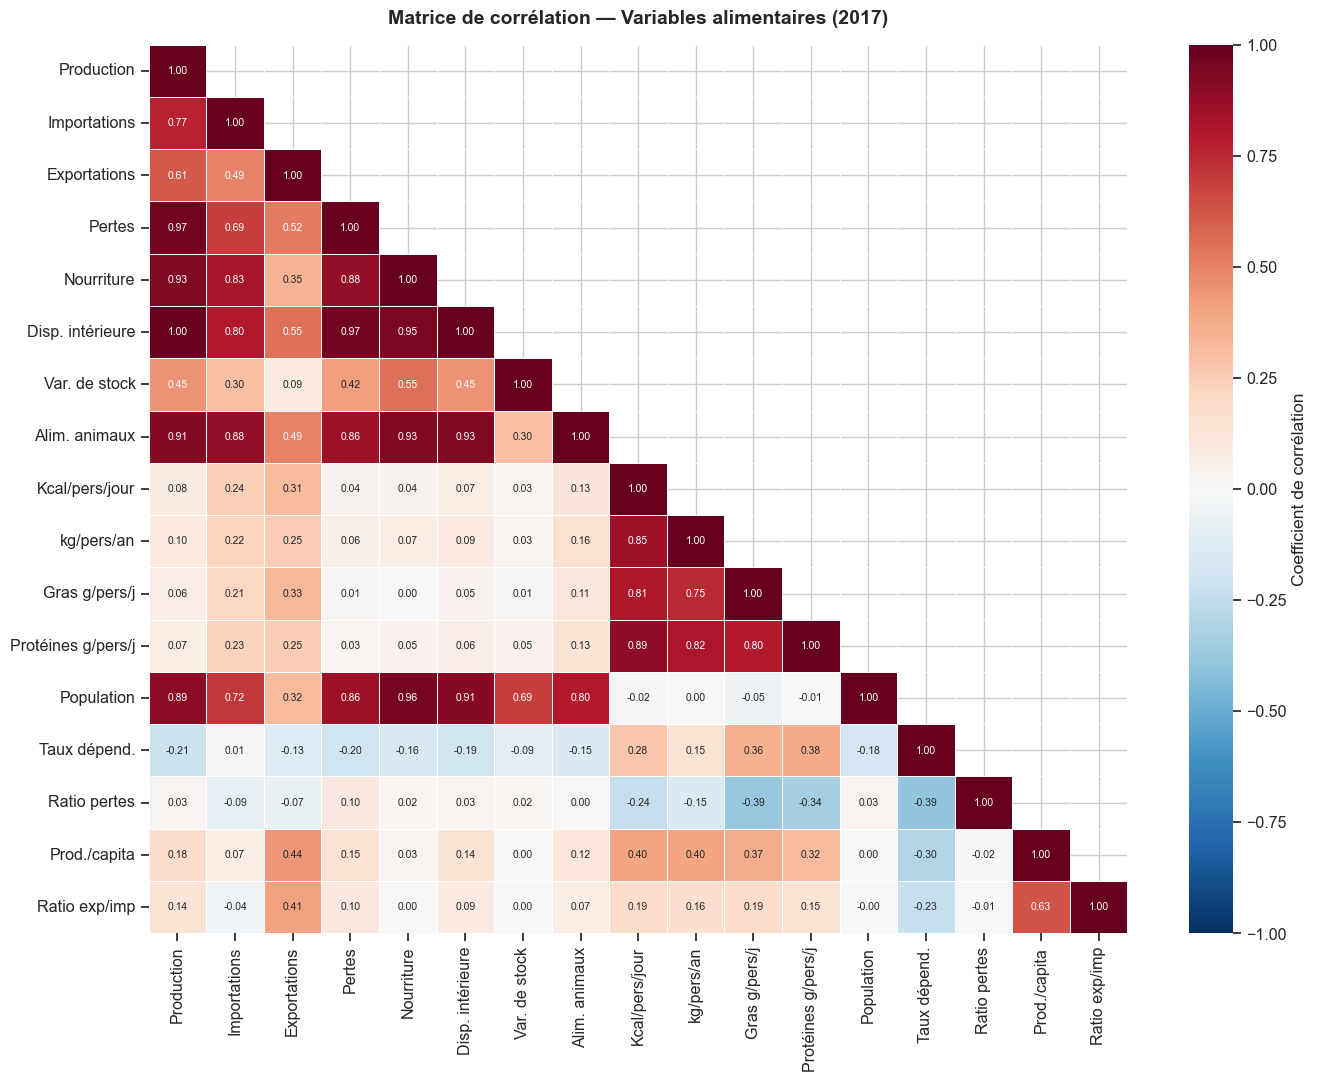

In [3]:
# --- Matrice de corrélation ---
corr_matrix = df_scaled.corr()

# Masque pour le triangle supérieur (évite la redondance)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Raccourcir les noms pour la lisibilité du graphique
short_labels = {
    'Production': 'Production',
    'Importations - Quantité': 'Importations',
    'Exportations - Quantité': 'Exportations',
    'Pertes': 'Pertes',
    'Nourriture': 'Nourriture',
    'Disponibilité intérieure': 'Disp. intérieure',
    'Variation de stock': 'Var. de stock',
    'Aliments pour animaux': 'Alim. animaux',
    'Disponibilité alimentaire (Kcal/personne/jour)': 'Kcal/pers/jour',
    'Disponibilité alimentaire en quantité (kg/personne/an)': 'kg/pers/an',
    'Disponibilité de matière grasse en quantité (g/personne/jour)': 'Gras g/pers/j',
    'Disponibilité de protéines en quantité (g/personne/jour)': 'Protéines g/pers/j',
    'Population_1000': 'Population',
    'Taux_dependance_alimentaire': 'Taux dépend.',
    'Ratio_pertes': 'Ratio pertes',
    'Production_par_capita': 'Prod./capita',
    'Ratio_export_import': 'Ratio exp/imp'
}
corr_plot = corr_matrix.rename(index=short_labels, columns=short_labels)

fig, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corr_plot, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, linewidths=0.5,
            annot_kws={'size': 7.5}, ax=ax,
            cbar_kws={'label': 'Coefficient de corrélation'})
ax.set_title('Matrice de corrélation — Variables alimentaires (2017)', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

In [4]:
# Lister les paires avec |r| > 0.7
print("=== Corrélations fortes (|r| > 0.70) ===")
print(f"{'Variable 1':<55} {'Variable 2':<55} {'r':>6}")
print('─' * 120)

pairs = []
for i in range(len(cols_num)):
    for j in range(i+1, len(cols_num)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.70:
            pairs.append((cols_num[i], cols_num[j], r))

pairs.sort(key=lambda x: -abs(x[2]))
for v1, v2, r in pairs:
    print(f"{v1:<55} {v2:<55} {r:>+.3f}")

print(f"\n→ {len(pairs)} paires avec |r| > 0.70")
print("→ Les variables volumétriques (Production, Nourriture, Disp. intérieure…) sont très corrélées")
print("  entre elles car elles sont toutes pondérées par la taille du pays.")
print("→ Les 4 variables 'par personne' forment un autre groupe corrélé (nutrition).")
print("→ L'ACP va condenser ces redondances en un petit nombre de axes synthétiques.")

=== Corrélations fortes (|r| > 0.70) ===
Variable 1                                              Variable 2                                                   r
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Production                                              Disponibilité intérieure                                +0.995
Production                                              Pertes                                                  +0.969
Pertes                                                  Disponibilité intérieure                                +0.967
Nourriture                                              Population_1000                                         +0.959
Nourriture                                              Disponibilité intérieure                                +0.952
Disponibilité intérieure                                Aliments pour animaux                                   +0.931
Nourr

---
## 3. Analyse en Composantes Principales (ACP)

### 3.1 — ACP complète & ébouli des valeurs propres

On fait d'abord une ACP sur **toutes** les composantes pour déterminer combien en retenir.

In [5]:
# ACP complète (nombre de composantes = nombre de variables)
pca_full = PCA()
pca_full.fit(X_scaled)

eigenvalues   = pca_full.explained_variance_
var_expliquee = pca_full.explained_variance_ratio_
var_cumulee   = np.cumsum(var_expliquee)

print("PC | Valeur propre | % variance | % cumulé")
print('─' * 50)
for i in range(len(eigenvalues)):
    marker = ' ◄' if eigenvalues[i] >= 1 and (i == len(eigenvalues)-1 or eigenvalues[i+1] < 1) else ''
    print(f" {i+1:>2} |    {eigenvalues[i]:>8.3f}    |  {var_expliquee[i]*100:>6.2f}%   |  {var_cumulee[i]*100:>6.2f}%{marker}")

print(f"\n→ Critère Kaiser (valeur propre > 1)        : {(eigenvalues >= 1).sum()} composantes")
print(f"→ Seuil 80% de variance expliquée atteint à : PC{np.argmax(var_cumulee >= 0.80)+1}")
print(f"→ Seuil 90% de variance expliquée atteint à : PC{np.argmax(var_cumulee >= 0.90)+1}")

PC | Valeur propre | % variance | % cumulé
──────────────────────────────────────────────────
  1 |       7.013    |   41.01%   |   41.01%
  2 |       4.036    |   23.60%   |   64.61%
  3 |       1.971    |   11.52%   |   76.14%
  4 |       1.025    |    5.99%   |   82.13% ◄
  5 |       0.914    |    5.34%   |   87.48%
  6 |       0.547    |    3.20%   |   90.68%
  7 |       0.440    |    2.57%   |   93.25%
  8 |       0.302    |    1.77%   |   95.02%
  9 |       0.288    |    1.68%   |   96.70%
 10 |       0.205    |    1.20%   |   97.90%
 11 |       0.144    |    0.84%   |   98.74%
 12 |       0.100    |    0.59%   |   99.33%
 13 |       0.057    |    0.33%   |   99.66%
 14 |       0.051    |    0.30%   |   99.96%
 15 |       0.006    |    0.03%   |   99.99%
 16 |       0.001    |    0.01%   |  100.00%
 17 |       0.000    |    0.00%   |  100.00%

→ Critère Kaiser (valeur propre > 1)        : 4 composantes
→ Seuil 80% de variance expliquée atteint à : PC4
→ Seuil 90% de variance expl

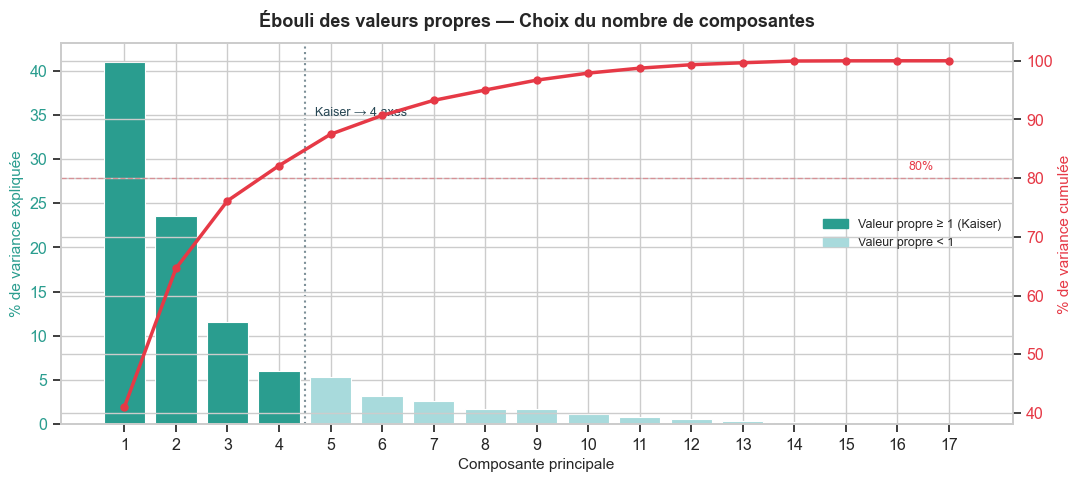


→ On retient 4 composantes : critère Kaiser (val. propre ≥ 1) + seuil 80% atteint à PC4 (82.1%).


In [6]:
# --- Ébouli des valeurs propres ---
fig, ax1 = plt.subplots(figsize=(11, 5))

n_comp_total = len(eigenvalues)
x_axis = np.arange(1, n_comp_total + 1)

# Barres : variance expliquée par composante
colors = ['#2A9D8F' if ev >= 1 else '#A8DADC' for ev in eigenvalues]
ax1.bar(x_axis, var_expliquee * 100, color=colors, edgecolor='white', linewidth=0.8, zorder=2)
ax1.set_xlabel('Composante principale', fontsize=11)
ax1.set_ylabel('% de variance expliquée', fontsize=11, color='#2A9D8F')
ax1.tick_params(axis='y', labelcolor='#2A9D8F')
ax1.set_xticks(x_axis)

# Ligne rouge : variance cumulée
ax2 = ax1.twinx()
ax2.plot(x_axis, var_cumulee * 100, color='#E63946', marker='o', linewidth=2.5, markersize=5, zorder=3)
ax2.set_ylabel('% de variance cumulée', fontsize=11, color='#E63946')
ax2.tick_params(axis='y', labelcolor='#E63946')

# Ligne horizontale à 80%
ax2.axhline(80, color='#E63946', linestyle='--', alpha=0.4, linewidth=1)
ax2.text(n_comp_total - 0.3, 81.5, '80%', color='#E63946', fontsize=9, ha='right')

# Ligne verticale après PC4 (Kaiser)
ax1.axvline(4.5, color='#264653', linestyle=':', alpha=0.6, linewidth=1.5)
ax1.text(4.7, max(var_expliquee)*100*0.85, 'Kaiser → 4 axes', color='#264653', fontsize=9)

# Légende
patch_kaiser = mpatches.Patch(color='#2A9D8F', label='Valeur propre ≥ 1 (Kaiser)')
patch_autre  = mpatches.Patch(color='#A8DADC', label='Valeur propre < 1')
ax1.legend(handles=[patch_kaiser, patch_autre], loc='center right', fontsize=9)

plt.title('Ébouli des valeurs propres — Choix du nombre de composantes', fontsize=13, fontweight='bold', pad=12)
plt.tight_layout()
plt.show()

print("\n→ On retient 4 composantes : critère Kaiser (val. propre ≥ 1) + seuil 80% atteint à PC4 (82.1%).")

### 3.2 — ACP finale sur 4 composantes & cercle des corrélations

In [7]:
# ACP restreinte à 4 composantes
n_comp = 4
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X_scaled)

# DataFrame des coordonnées des individus (pays) sur les axes
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_comp)], index=df.index)
df_pca['Zone'] = df['Zone'].values

# Loadings (coordonnées des variables sur les axes)
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(n_comp)],
                        index=cols_num)

print("=== Variance expliquée par axe ===")
for i in range(n_comp):
    print(f"  PC{i+1} : {pca.explained_variance_ratio_[i]*100:.2f}%")
print(f"  Total : {pca.explained_variance_ratio_.sum()*100:.2f}%")

print("\n=== Top 3 variables par composante ===")
for i in range(n_comp):
    col = f'PC{i+1}'
    top3 = loadings[col].abs().sort_values(ascending=False).head(3)
    print(f"\n  {col} ({pca.explained_variance_ratio_[i]*100:.1f}%) :")
    for var in top3.index:
        print(f"    {var:<60} loading = {loadings.loc[var, col]:>+.3f}")

=== Variance expliquée par axe ===
  PC1 : 41.01%
  PC2 : 23.60%
  PC3 : 11.52%
  PC4 : 5.99%
  Total : 82.13%

=== Top 3 variables par composante ===

  PC1 (41.0%) :
    Disponibilité intérieure                                     loading = +0.370
    Production                                                   loading = +0.369
    Nourriture                                                   loading = +0.357

  PC2 (23.6%) :
    Disponibilité alimentaire (Kcal/personne/jour)               loading = +0.449
    Disponibilité de protéines en quantité (g/personne/jour)     loading = +0.445
    Disponibilité de matière grasse en quantité (g/personne/jour) loading = +0.443

  PC3 (11.5%) :
    Ratio_export_import                                          loading = +0.527
    Production_par_capita                                        loading = +0.509
    Taux_dependance_alimentaire                                  loading = -0.482

  PC4 (6.0%) :
    Ratio_pertes                           

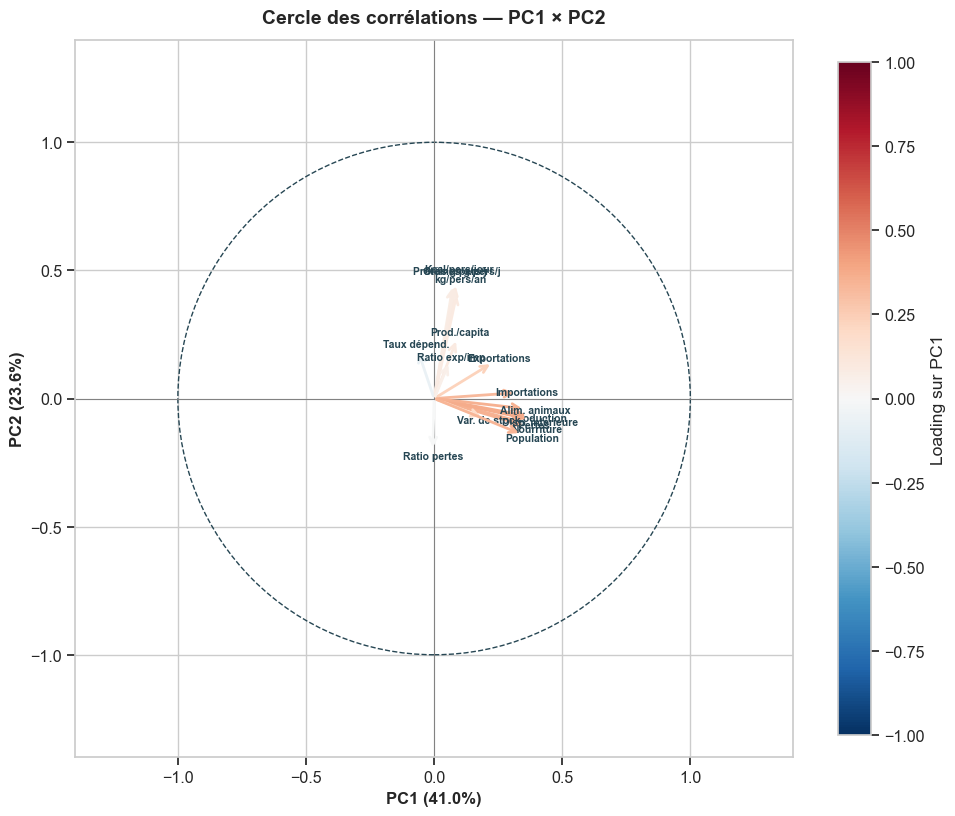

In [8]:
# --- Cercle des corrélations : PC1 vs PC2 ---
fig, ax = plt.subplots(figsize=(10, 10))

# Cercle unité
circle = plt.Circle((0, 0), 1, fill=False, color='#264653', linestyle='--', linewidth=1)
ax.add_patch(circle)

# Colormap : intensité de la corrélation avec PC1
corr_pc1 = loadings['PC1'].values
norm = plt.Normalize(vmin=-1, vmax=1)
cmap = plt.cm.RdBu_r

for i, var in enumerate(cols_num):
    x, y = loadings.loc[var, 'PC1'], loadings.loc[var, 'PC2']
    color = cmap(norm(corr_pc1[i]))
    ax.annotate('', xy=(x, y), xytext=(0, 0),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))
    # Raccourcir le label
    label = short_labels.get(var, var)
    ax.text(x * 1.12, y * 1.12, label, ha='center', va='center',
            fontsize=7.5, fontweight='bold', color='#264653')

# Axes
ax.axhline(0, color='gray', linewidth=0.7)
ax.axvline(0, color='gray', linewidth=0.7)
ax.set_xlim(-1.4, 1.4)
ax.set_ylim(-1.4, 1.4)
ax.set_aspect('equal')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_title('Cercle des corrélations — PC1 × PC2', fontsize=14, fontweight='bold', pad=12)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Loading sur PC1', shrink=0.7)

plt.tight_layout()
plt.show()

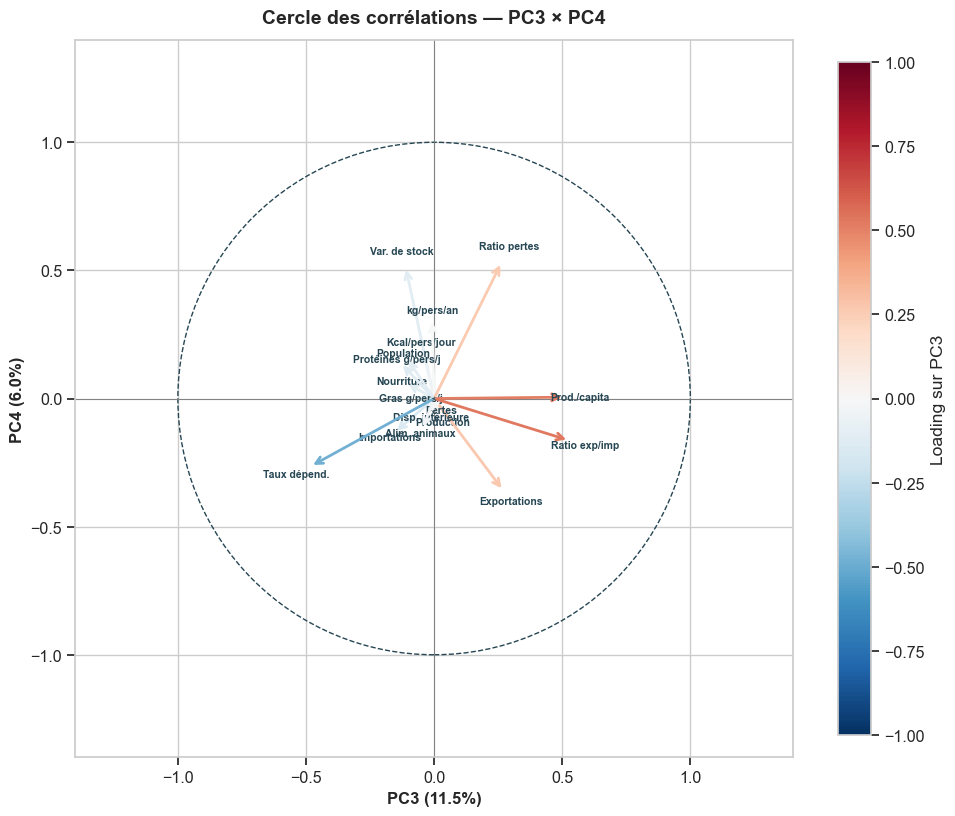

In [9]:
# --- Cercle des corrélations : PC3 vs PC4 ---
fig, ax = plt.subplots(figsize=(10, 10))

circle = plt.Circle((0, 0), 1, fill=False, color='#264653', linestyle='--', linewidth=1)
ax.add_patch(circle)

corr_pc3 = loadings['PC3'].values

for i, var in enumerate(cols_num):
    x, y = loadings.loc[var, 'PC3'], loadings.loc[var, 'PC4']
    color = cmap(norm(corr_pc3[i]))
    ax.annotate('', xy=(x, y), xytext=(0, 0),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))
    label = short_labels.get(var, var)
    ax.text(x * 1.12, y * 1.12, label, ha='center', va='center',
            fontsize=7.5, fontweight='bold', color='#264653')

ax.axhline(0, color='gray', linewidth=0.7)
ax.axvline(0, color='gray', linewidth=0.7)
ax.set_xlim(-1.4, 1.4)
ax.set_ylim(-1.4, 1.4)
ax.set_aspect('equal')
ax.set_xlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC4 ({pca.explained_variance_ratio_[3]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_title('Cercle des corrélations — PC3 × PC4', fontsize=14, fontweight='bold', pad=12)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Loading sur PC3', shrink=0.7)

plt.tight_layout()
plt.show()

### 3.3 — Projection des individus (pays) sur les axes

On projette les 170 pays sur PC1 × PC2 pour voir comment ils se répartissent.

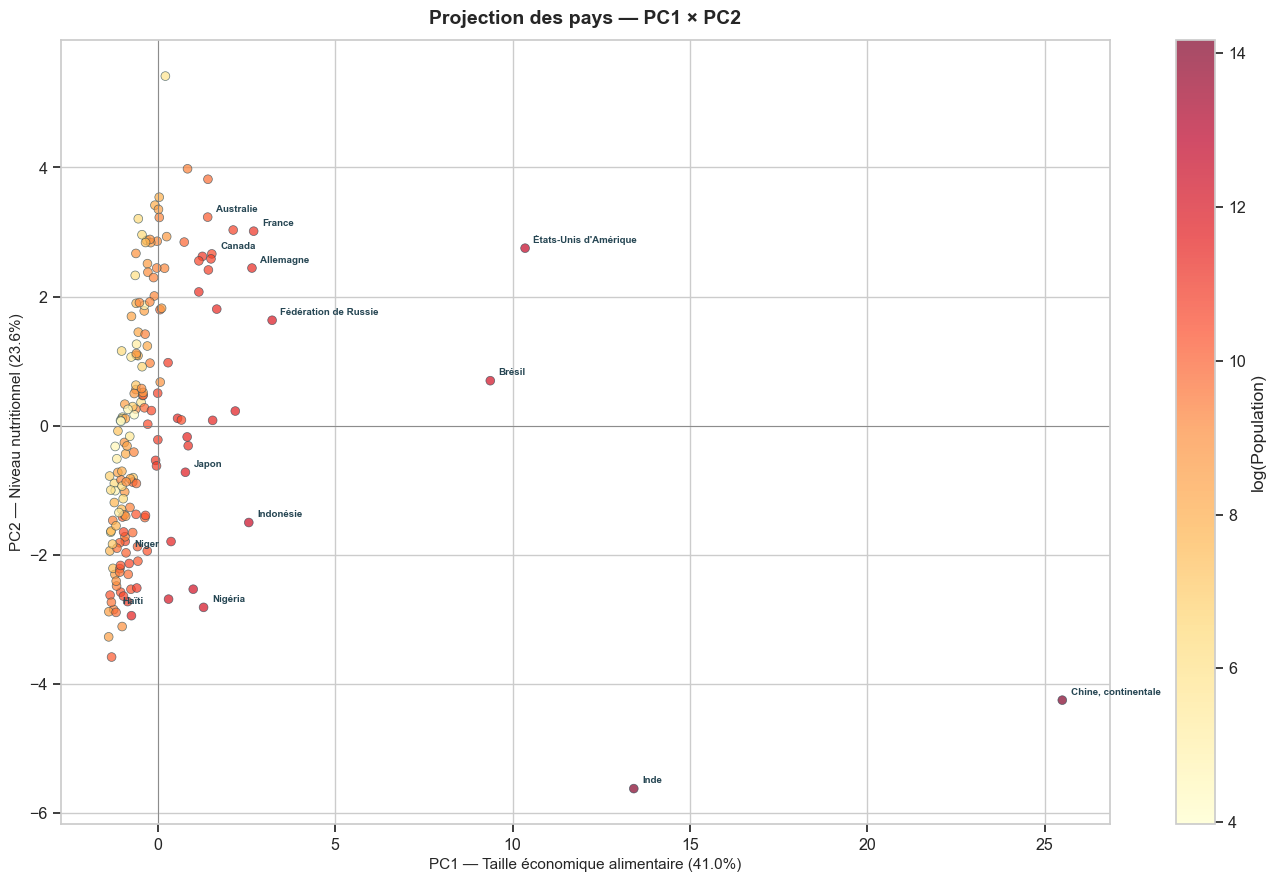

In [10]:
# --- Projection individus PC1 x PC2 ---
fig, ax = plt.subplots(figsize=(14, 9))

# Colorer par Population pour donner une dimension supplémentaire
pop_log = np.log1p(df['Population_1000'].values)

sc = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=pop_log, cmap='YlOrRd',
                s=40, alpha=0.7, edgecolors='#264653', linewidths=0.5, zorder=2)

# Labeller les pays remarquables
pays_remarquables = ['Chine, continentale', "États-Unis d'Amérique", 'Inde', 'Brésil',
                     'Allemagne', 'France', 'Japon', 'Australie', 'Niger', 'Haïti',
                     'Indonésie', 'Nigéria', 'Fédération de Russie', 'Canada']

for idx, row in df_pca.iterrows():
    if row['Zone'] in pays_remarquables:
        ax.annotate(row['Zone'], (row['PC1'], row['PC2']),
                    fontsize=7, fontweight='bold', color='#264653',
                    xytext=(6, 4), textcoords='offset points')

ax.axhline(0, color='gray', linewidth=0.6)
ax.axvline(0, color='gray', linewidth=0.6)
ax.set_xlabel(f'PC1 — Taille économique alimentaire ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC2 — Niveau nutritionnel ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax.set_title('Projection des pays — PC1 × PC2', fontsize=14, fontweight='bold', pad=12)

plt.colorbar(sc, ax=ax, label='log(Population)')
plt.tight_layout()
plt.show()

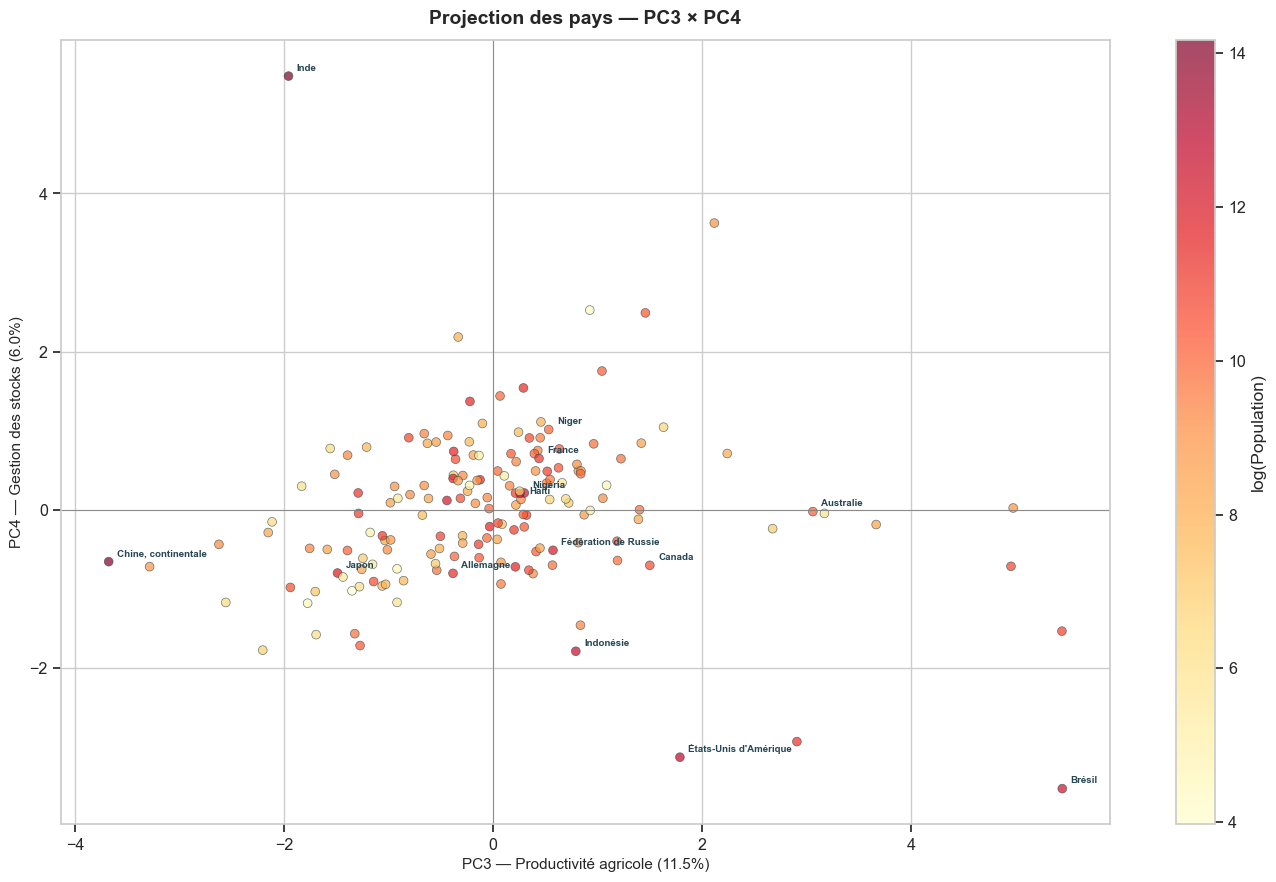

In [11]:
# --- Projection individus PC3 x PC4 ---
fig, ax = plt.subplots(figsize=(14, 9))

sc = ax.scatter(df_pca['PC3'], df_pca['PC4'], c=pop_log, cmap='YlOrRd',
                s=40, alpha=0.7, edgecolors='#264653', linewidths=0.5, zorder=2)

for idx, row in df_pca.iterrows():
    if row['Zone'] in pays_remarquables:
        ax.annotate(row['Zone'], (row['PC3'], row['PC4']),
                    fontsize=7, fontweight='bold', color='#264653',
                    xytext=(6, 4), textcoords='offset points')

ax.axhline(0, color='gray', linewidth=0.6)
ax.axvline(0, color='gray', linewidth=0.6)
ax.set_xlabel(f'PC3 — Productivité agricole ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC4 — Gestion des stocks ({pca.explained_variance_ratio_[3]*100:.1f}%)', fontsize=11)
ax.set_title('Projection des pays — PC3 × PC4', fontsize=14, fontweight='bold', pad=12)

plt.colorbar(sc, ax=ax, label='log(Population)')
plt.tight_layout()
plt.show()

### 3.4 — Interprétation des 4 axes

| Axe | % var | Interprétation |
|-----|-------|----------------|
| **PC1** | 41.0% | **Taille économique alimentaire** — Les pays avec une grande production, disponibilité intérieure et population sont à droite. Les petits pays sont à gauche. |
| **PC2** | 23.6% | **Niveau nutritionnel** — En haut : pays avec une forte disponibilité alimentaire par personne (Kcal, protéines, graisses). En bas : pays sous-alimentés. |
| **PC3** | 11.5% | **Productivité agricole & position commerciale** — À droite : pays exportateurs nets avec une forte production par capita. À gauche : pays dépendants des importations. |
| **PC4** | 6.0%  | **Gestion des réserves & pertes** — Discrimine les pays selon leur ratio de pertes et la variabilité de leurs stocks alimentaires. |

---
## 4. Clustering

On applique les données de l'ACP (4 composantes) pour le clustering.

> **Pourquoi les données ACP et pas les données originales ?**
> Les données originales ont 17 variables très corrélées entre elles. Le clustering sur ces données donne un score silhouette plus faible (voir tableau ci-dessous). L'ACP retire la redondance et condense l'information en 4 axes orthogonaux, ce qui rend les distances plus significatives pour le clustering.

### 4.1 — CAH (Clustering Ascendant Hiérarchique) avec linkage Ward

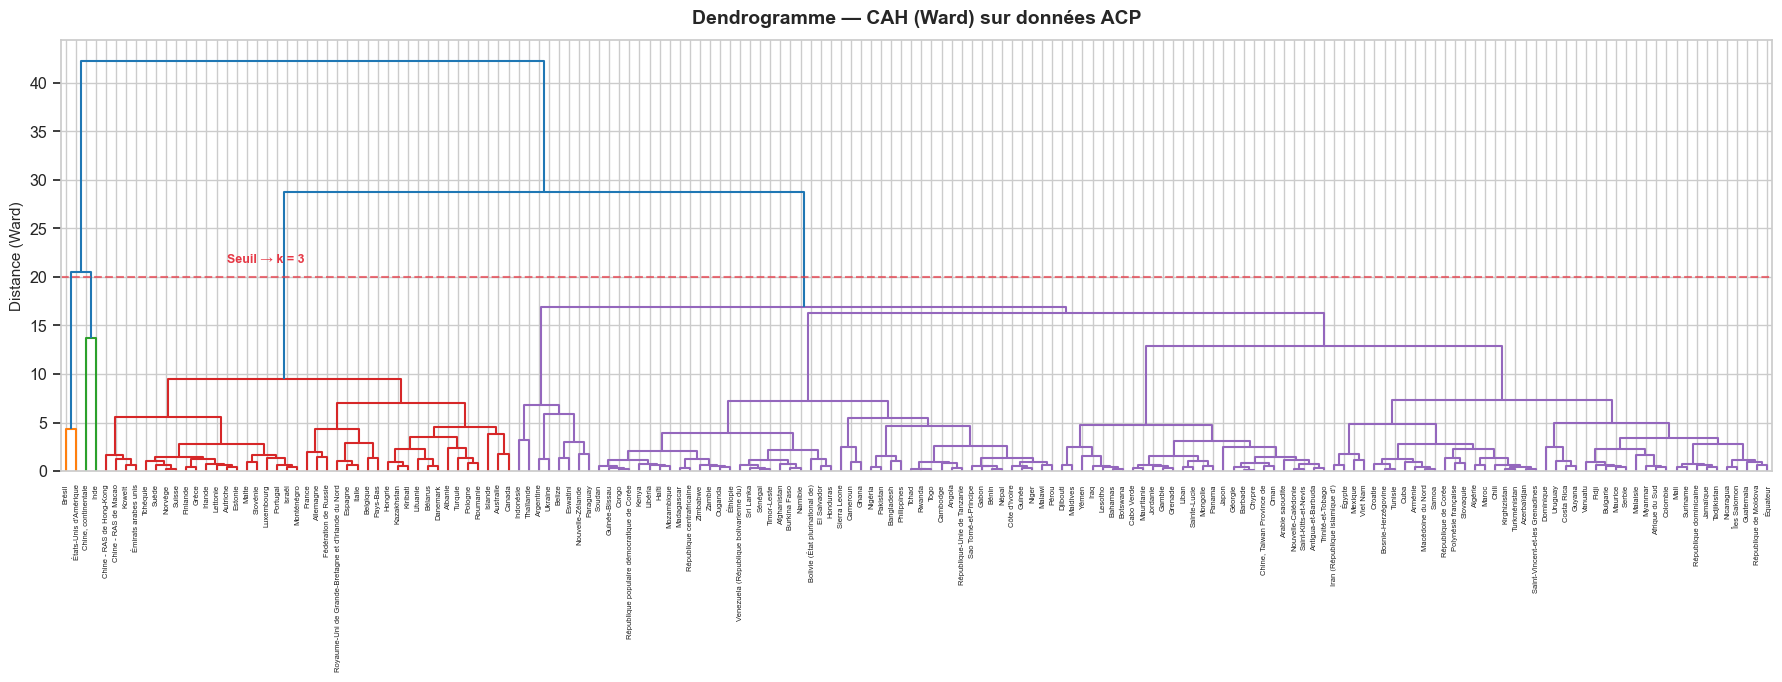

In [12]:
# Linkage Ward sur les données ACP
Z = linkage(X_pca, method='ward')

# --- Dendrogramme ---
fig, ax = plt.subplots(figsize=(18, 7))

dendrogram(Z, labels=df['Zone'].values, leaf_rotation=90, leaf_font_size=5.5,
           color_threshold=20, ax=ax)

# Ligne horizontale pour k=3
ax.axhline(y=20, color='#E63946', linestyle='--', linewidth=1.5, alpha=0.7)
ax.text(len(df)-5, 21.5, 'Seuil → k = 3', color='#E63946', fontsize=9, fontweight='bold')

ax.set_title('Dendrogramme — CAH (Ward) sur données ACP', fontsize=14, fontweight='bold', pad=12)
ax.set_ylabel('Distance (Ward)', fontsize=11)
ax.set_xlabel('')

plt.tight_layout()
plt.show()

### 4.2 — Détermination du nombre optimal de clusters

In [13]:
# --- Silhouette : CAH vs KMeans, données PCA vs originales ---
Z_orig = linkage(X_scaled, method='ward')

K_range = range(2, 8)
results = []

for k in K_range:
    l_pca_cah  = fcluster(Z,      k, criterion='maxclust')
    l_pca_km   = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_pca)
    l_orig_cah = fcluster(Z_orig, k, criterion='maxclust')
    l_orig_km  = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_scaled)

    results.append({
        'k': k,
        'PCA — CAH':   silhouette_score(X_pca,    l_pca_cah),
        'PCA — KMeans': silhouette_score(X_pca,    l_pca_km),
        'Orig — CAH':  silhouette_score(X_scaled, l_orig_cah),
        'Orig — KMeans': silhouette_score(X_scaled, l_orig_km)
    })

df_sil = pd.DataFrame(results).set_index('k')
print("=== Silhouette Score : PCA vs Données originales ===")
print(df_sil.round(3).to_string())
print("\n→ Les données PCA donnent systématiquement un meilleur silhouette.")
print("→ On utilise donc les données ACP pour le clustering.")

=== Silhouette Score : PCA vs Données originales ===
   PCA — CAH  PCA — KMeans  Orig — CAH  Orig — KMeans
k                                                    
2      0.780         0.824       0.760          0.760
3      0.363         0.369       0.322          0.295
4      0.369         0.375       0.327          0.317
5      0.388         0.330       0.327          0.309
6      0.272         0.304       0.323          0.307
7      0.270         0.304       0.186          0.239

→ Les données PCA donnent systématiquement un meilleur silhouette.
→ On utilise donc les données ACP pour le clustering.


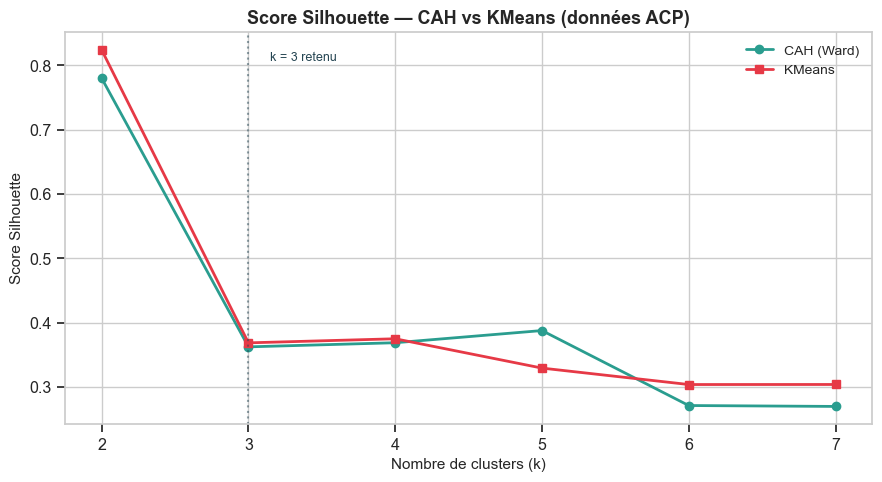


→ k=2 donne le meilleur silhouette mais est trivial (4 pays géants vs le reste).
→ k=3 est le meilleur compromis : separation Claire en 3 groupes cohérents.
→ Au-delà de k=3, le silhouette ne s'améliore pas de façon significative.


In [14]:
# --- Graphique Silhouette ---
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(df_sil.index, df_sil['PCA — CAH'],    marker='o', linewidth=2, color='#2A9D8F', label='CAH (Ward)')
ax.plot(df_sil.index, df_sil['PCA — KMeans'], marker='s', linewidth=2, color='#E63946', label='KMeans')

# Marquer le meilleur k (k=3 pour les deux)
ax.axvline(3, color='#264653', linestyle=':', alpha=0.5)
ax.text(3.15, df_sil['PCA — KMeans'].max()*0.98, 'k = 3 retenu', color='#264653', fontsize=9)

ax.set_xlabel('Nombre de clusters (k)', fontsize=11)
ax.set_ylabel('Score Silhouette', fontsize=11)
ax.set_title('Score Silhouette — CAH vs KMeans (données ACP)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.set_xticks(list(K_range))

plt.tight_layout()
plt.show()

print("\n→ k=2 donne le meilleur silhouette mais est trivial (4 pays géants vs le reste).")
print("→ k=3 est le meilleur compromis : separation Claire en 3 groupes cohérents.")
print("→ Au-delà de k=3, le silhouette ne s'améliore pas de façon significative.")

### 4.3 — KMeans avec k=3 & méthode du coude

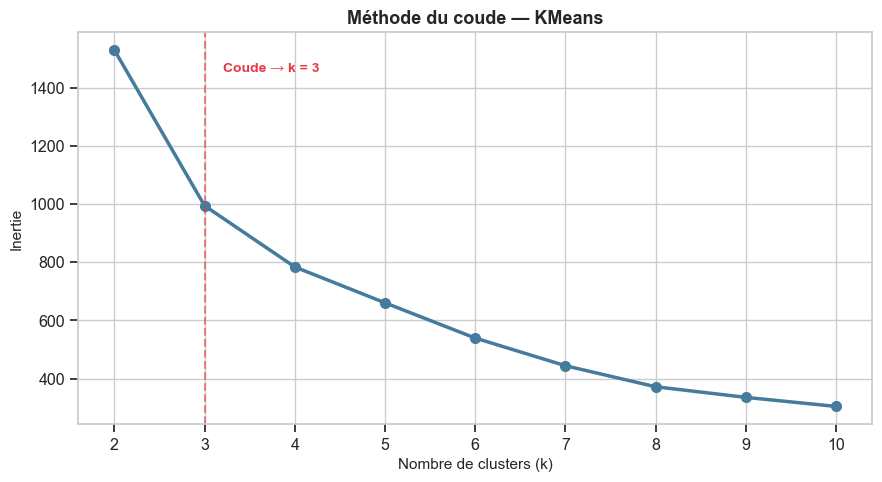

In [15]:
# --- Méthode du coude ---
K_range_coude = range(2, 11)
inertias = []
for k in K_range_coude:
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca).inertia_)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(list(K_range_coude), inertias, marker='o', color='#457B9D', linewidth=2.5, markersize=7)
ax.axvline(3, color='#E63946', linestyle='--', alpha=0.6)
ax.text(3.2, max(inertias)*0.95, 'Coude → k = 3', color='#E63946', fontsize=10, fontweight='bold')

ax.set_xlabel('Nombre de clusters (k)', fontsize=11)
ax.set_ylabel('Inertie', fontsize=11)
ax.set_title('Méthode du coude — KMeans', fontsize=13, fontweight='bold')
ax.set_xticks(list(K_range_coude))

plt.tight_layout()
plt.show()

In [16]:
# --- KMeans k=3 final ---
km = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster_KMeans'] = km.fit_predict(X_pca)

# Renommer les clusters de manière interprétable
# On identifie chaque cluster par son profil
cluster_sizes = df['Cluster_KMeans'].value_counts().to_dict()
print("Tailles des clusters KMeans :")
for c, n in sorted(cluster_sizes.items()):
    pays_ex = df[df['Cluster_KMeans']==c]['Zone'].head(3).tolist()
    print(f"  Cluster {c} : {n} pays — ex: {pays_ex}")

Tailles des clusters KMeans :
  Cluster 0 : 90 pays — ex: ['Afghanistan', 'Afrique du Sud', 'Angola']
  Cluster 1 : 4 pays — ex: ['Brésil', 'Chine, continentale', 'Inde']
  Cluster 2 : 76 pays — ex: ['Albanie', 'Algérie', 'Allemagne']


### 4.4 — Comparaison CAH vs KMeans (k=3)

In [17]:
# Labels CAH k=3
df['Cluster_CAH'] = fcluster(Z, 3, criterion='maxclust')

# Tableau de contingence
contingence = pd.crosstab(df['Cluster_CAH'], df['Cluster_KMeans'])
contingence.index.name = 'CAH \\ KMeans'
print("=== Tableau de contingence : CAH vs KMeans ===")
print(contingence)

print("\n→ Les deux méthodes identifient les mêmes 3 groupes principaux.")
print("→ Le cluster des 4 pays géants est identique dans les deux méthodes.")
print("→ La différence principale : KMeans répartit plus équitablement les pays")
print("  entre les deux autres clusters (90/76) vs CAH (41/125).")
print("→ KMeans est plus équilibré et sera utilisé pour l'interprétation finale.")

=== Tableau de contingence : CAH vs KMeans ===
Cluster_KMeans   0  1   2
CAH \ KMeans             
1                0  4   0
2                0  0  41
3               90  0  35

→ Les deux méthodes identifient les mêmes 3 groupes principaux.
→ Le cluster des 4 pays géants est identique dans les deux méthodes.
→ La différence principale : KMeans répartit plus équitablement les pays
  entre les deux autres clusters (90/76) vs CAH (41/125).
→ KMeans est plus équilibré et sera utilisé pour l'interprétation finale.


---
## 5. Interprétation des clusters & visualisation finale

In [18]:
# Nommer les clusters selon leur profil
# Cluster avec 4 pays (Brésil, Chine, Inde, USA) = puissances agricoles
# Cluster avec ~76 pays (Allemagne, France, etc.) = économies développées
# Cluster avec ~90 pays (pays en développement) = économies en développement

# Identifier automatiquement
cluster_4pays = df['Cluster_KMeans'].value_counts().idxmin()  # le plus petit = 4 pays
remaining = [c for c in df['Cluster_KMeans'].unique() if c != cluster_4pays]

# Entre les deux restants, celui avec la plus haute Kcal moyenne = développé
kcal_col = 'Disponibilité alimentaire (Kcal/personne/jour)'
moy_kcal = {c: df[df['Cluster_KMeans']==c][kcal_col].mean() for c in remaining}
cluster_dev = max(moy_kcal, key=moy_kcal.get)
cluster_endev = [c for c in remaining if c != cluster_dev][0]

noms = {
    cluster_4pays:  'A — Puissances agricoles',
    cluster_dev:    'B — Économies développées',
    cluster_endev:  'C — En développement'
}
df['Cluster_nom'] = df['Cluster_KMeans'].map(noms)

print("=== Clusters nommés ===")
for c, nom in noms.items():
    pays = df[df['Cluster_KMeans']==c]['Zone'].tolist()
    print(f"\n  {nom} ({len(pays)} pays) :")
    print(f"    {pays}")

=== Clusters nommés ===

  A — Puissances agricoles (4 pays) :
    ['Brésil', 'Chine, continentale', 'Inde', "États-Unis d'Amérique"]

  B — Économies développées (76 pays) :
    ['Albanie', 'Algérie', 'Allemagne', 'Argentine', 'Arménie', 'Australie', 'Autriche', 'Azerbaïdjan', 'Belgique', 'Belize', 'Bosnie-Herzégovine', 'Bulgarie', 'Bélarus', 'Canada', 'Chili', 'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao', 'Chine, Taiwan Province de', 'Costa Rica', 'Croatie', 'Cuba', 'Danemark', 'Dominique', 'Espagne', 'Estonie', 'Fidji', 'Finlande', 'France', 'Fédération de Russie', 'Grèce', 'Guyana', 'Hongrie', "Iran (République islamique d')", 'Irlande', 'Islande', 'Israël', 'Italie', 'Kazakhstan', 'Kirghizistan', 'Kiribati', 'Koweït', 'Lettonie', 'Lituanie', 'Luxembourg', 'Macédoine du Nord', 'Malaisie', 'Malte', 'Maroc', 'Maurice', 'Mexique', 'Monténégro', 'Norvège', 'Nouvelle-Zélande', 'Paraguay', 'Pays-Bas', 'Pologne', 'Polynésie française', 'Portugal', 'Roumanie', "Royaume-Uni de Grande-

In [19]:
# --- Profils moyens par cluster ---
profil_vars = [
    'Disponibilité alimentaire (Kcal/personne/jour)',
    'Disponibilité de protéines en quantité (g/personne/jour)',
    'Disponibilité de matière grasse en quantité (g/personne/jour)',
    'Production_par_capita',
    'Taux_dependance_alimentaire',
    'Ratio_pertes',
    'Ratio_export_import'
]

profil_short = {
    'Disponibilité alimentaire (Kcal/personne/jour)': 'Kcal / pers / jour',
    'Disponibilité de protéines en quantité (g/personne/jour)': 'Protéines (g/pers/j)',
    'Disponibilité de matière grasse en quantité (g/personne/jour)': 'Graisses (g/pers/j)',
    'Production_par_capita': 'Production / capita',
    'Taux_dependance_alimentaire': 'Taux dépendance',
    'Ratio_pertes': 'Ratio pertes',
    'Ratio_export_import': 'Ratio export/import'
}

df_profil = df.groupby('Cluster_nom')[profil_vars].mean()
df_profil.index = [n for n in ['A — Puissances agricoles', 'B — Économies développées', 'C — En développement']]
df_profil.columns = [profil_short.get(c, c) for c in df_profil.columns]

print("=== Profil moyen par cluster ===")
print(df_profil.round(3).T.to_string())

=== Profil moyen par cluster ===
                      A — Puissances agricoles  B — Économies développées  C — En développement
Kcal / pers / jour                      36.147                     39.074                29.642
Protéines (g/pers/j)                     1.055                      1.177                 0.781
Graisses (g/pers/j)                      1.264                      1.401                 0.750
Production / capita                      2.818                      2.139                 0.938
Taux dépendance                          0.058                      0.394                 0.292
Ratio pertes                             0.064                      0.043                 0.059
Ratio export/import                      3.098                      2.125                 0.589


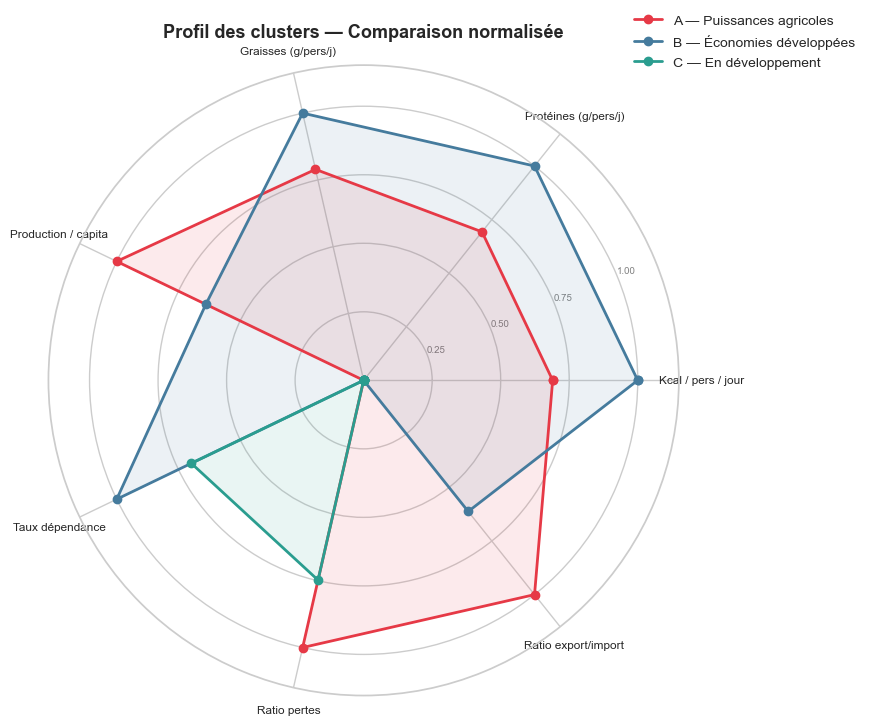

In [20]:
# --- Graphique radar (spider) des profils normalisés ---
from matplotlib.patches import FancyBboxPatch

# Normaliser les profils entre 0 et 1 pour chaque variable
df_norm = df_profil.copy()
for col in df_norm.columns:
    min_v, max_v = df_norm[col].min(), df_norm[col].max()
    if max_v - min_v > 0:
        df_norm[col] = (df_norm[col] - min_v) / (max_v - min_v)
    else:
        df_norm[col] = 0.5

# Paramètres du radar
categories = list(df_norm.columns)
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # fermer le polygone

colors_radar = ['#E63946', '#457B9D', '#2A9D8F']
labels_radar = list(df_norm.index)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

for i, (label, color) in enumerate(zip(labels_radar, colors_radar)):
    values = df_norm.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=label, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=8.5)
ax.set_ylim(0, 1.15)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.25', '0.50', '0.75', '1.00'], fontsize=7, color='gray')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.set_title('Profil des clusters — Comparaison normalisée', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

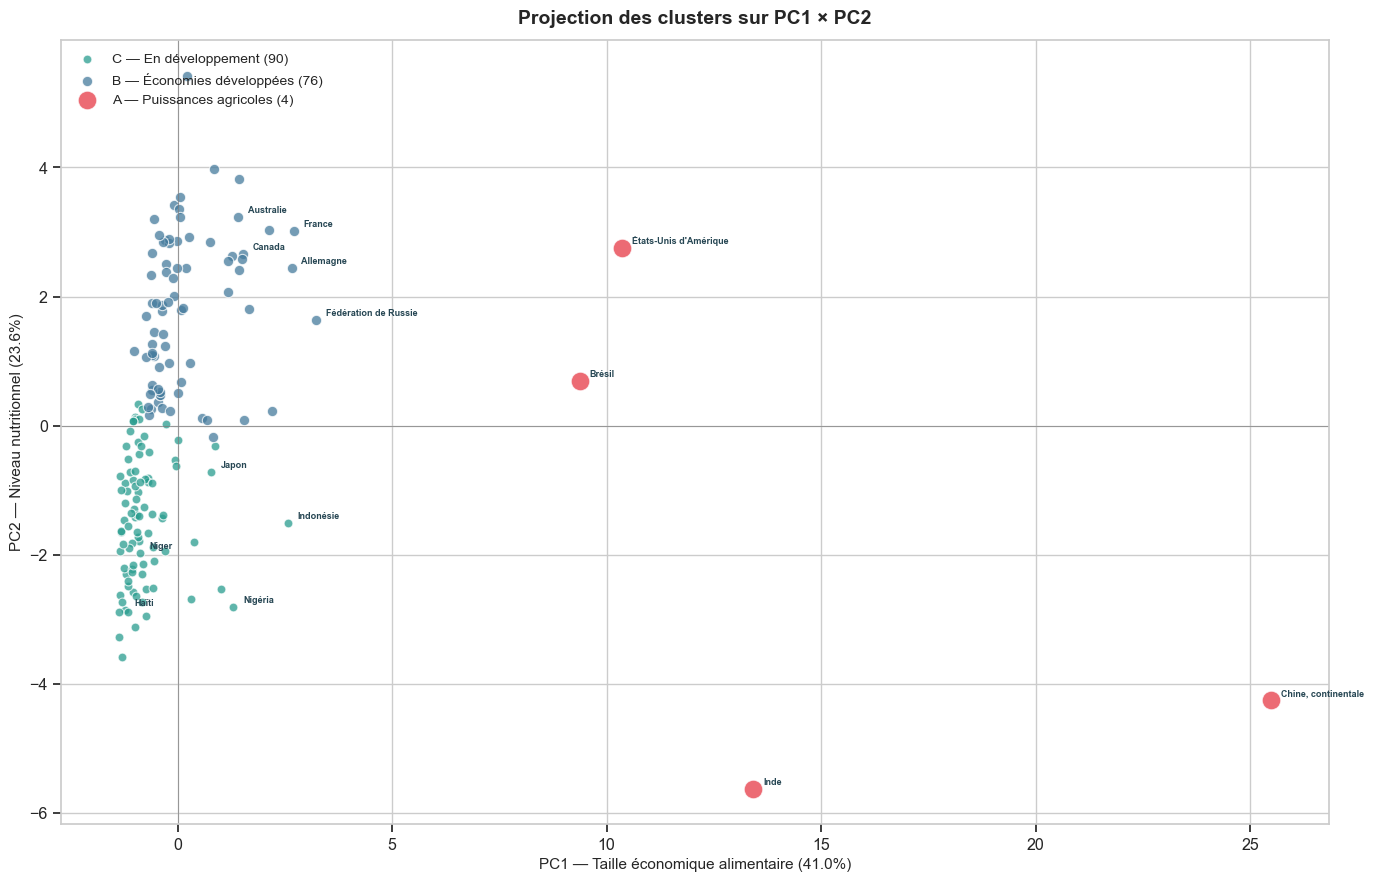

In [21]:
# --- Projection PC1 x PC2 colorée par cluster ---
fig, ax = plt.subplots(figsize=(14, 9))

color_map = {
    'A — Puissances agricoles':  '#E63946',
    'B — Économies développées': '#457B9D',
    'C — En développement':      '#2A9D8F'
}
size_map  = {
    'A — Puissances agricoles':  180,
    'B — Économies développées': 55,
    'C — En développement':      40
}

for cluster_nom in ['C — En développement', 'B — Économies développées', 'A — Puissances agricoles']:
    mask = df['Cluster_nom'] == cluster_nom
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=color_map[cluster_nom], s=size_map[cluster_nom],
               label=f"{cluster_nom} ({mask.sum()})",
               alpha=0.75, edgecolors='white', linewidths=0.8, zorder=2)

# Labels pays remarquables
for idx, row in df_pca.iterrows():
    if row['Zone'] in pays_remarquables:
        ax.annotate(row['Zone'], (row['PC1'], row['PC2']),
                    fontsize=6.5, fontweight='bold', color='#264653',
                    xytext=(7, 3), textcoords='offset points')

ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlabel(f'PC1 — Taille économique alimentaire ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC2 — Niveau nutritionnel ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax.set_title('Projection des clusters sur PC1 × PC2', fontsize=14, fontweight='bold', pad=12)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

---
## 6. Conclusion & Recommandations

### Résumé des 3 clusters

| Cluster | Pays | Profil |
|---------|------|--------|
| **A — Puissances agricoles** | 4 (Brésil, Chine, Inde, USA) | Production massive, très faible dépendance aux imports, exportateurs nets. Ce sont les moteurs mondials de l'alimentation. |
| **B — Économies développées** | ~76 (UE, Japon, Australie…) | Niveau nutritionnel élevé, production par capita forte, mais dépendance modérée aux importations. Chaîne d'approvisionnement efficace (peu de pertes). |
| **C — En développement** | ~90 (Afrique, Asie du Sud…) | Disponibilité alimentaire la plus faible, production par capita basse, exportateurs très faibles. Les plus vulnérables à l'insécurité alimentaire. |

### Recommandations pour une entreprise
- **Cluster A** : Opportunité de partenariat en amont (approvisionnement en matières brutes).
- **Cluster B** : Marché cible pour des produits transformés à haute valeur ajoutée.
- **Cluster C** : Marché à potentiel avec des besoins importants en alimentation de base — opportunité dans les produits essentiels et les programmes de développement.

In [22]:
# Export du DataFrame final avec les clusters
df_export = df[['Zone','Cluster_nom'] + cols_num].copy()
df_export.to_csv('resultats_clustering.csv', index=False, encoding='utf-8')
print("✓ Exporté : resultats_clustering.csv")
print(f"  {len(df_export)} pays, {df_export.shape[1]} colonnes")
print(f"\n  Répartition des clusters :")
print(df_export['Cluster_nom'].value_counts())

✓ Exporté : resultats_clustering.csv
  170 pays, 19 colonnes

  Répartition des clusters :
Cluster_nom
C — En développement         90
B — Économies développées    76
A — Puissances agricoles      4
Name: count, dtype: int64
